In [1]:
from obspy import read
from obspy.core import UTCDateTime
import numpy as np
from matplotlib import mlab
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import math as M
import matplotlib

%matplotlib inline

# site / node / instrument (hydrophone)
data_url = 'https://rawdata.oceanobservatories.org/files/CE02SHBP/LJ01D/11-HYDBBA106/2016/01/18/OO-HYEA2--YDH-2016-01-18T10:20:00.000000.mseed'
#localFileName = '../data/merged_hydrophone.mseed'

# Read Data

In [2]:
stream = read(data_url)         # Read from url
#stream = read(localFileName)   # Read from local file 
stream  # print some stats about this signal

1 Trace(s) in Stream:
OO.HYEA2..YDH | 2016-01-18T10:20:00.000000Z - 2016-01-18T10:24:59.998984Z | 64000.0 Hz, 19199936 samples

In [5]:
samp_rate = stream[0].stats.sampling_rate
t_start = stream[0].stats.starttime
t_end = stream[0].stats.endtime
duration = t_end-t_start
stream[0].stats

         network: OO
         station: HYEA2
        location: 
         channel: YDH
       starttime: 2016-01-18T10:20:00.000000Z
         endtime: 2016-01-18T10:24:59.998984Z
   sampling_rate: 64000.0
           delta: 1.5625e-05
            npts: 19199936
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 9691, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 39694336})

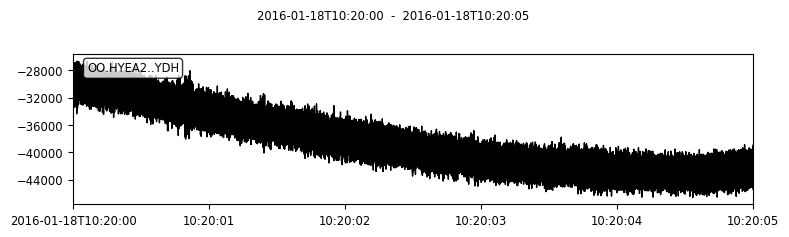

In [6]:
tr = stream[0]

step_size = 5 # for ploting the spectrogtam 
st = stream.slice((t_start), t_start + step_size)
trace = st[0].copy()
trace.plot()

4096


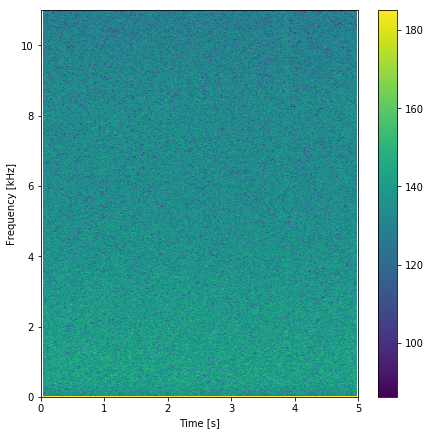

In [7]:
def _nearest_pow_2(x):

    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

wlen = 0.056;  # bin size in sec 
npts = len(st[0])
end = npts / samp_rate
nfft = int(_nearest_pow_2(wlen * samp_rate))  # number of fft points of each bin
print(nfft)
per_lap = 0.995      # percentage of overlap
nlap = int(nfft * float(per_lap))   # number of overlapped samples

# using mlab to create the array of spectrogram 
specgram, freq, time = mlab.specgram(trace.data/1e-6,NFFT = nfft,Fs = samp_rate,noverlap = nlap, pad_to = None)
specgram = 10 * np.log10(specgram[1:, :])
specgram = np.flipud(specgram)
freq = freq[1:] / 1e3  # Convert Frequency to kHz
halfbin_time = (time[1] - time[0]) / 2.0
halfbin_freq = (freq[1] - freq[0]) / 2.0
freq = np.concatenate((freq, [freq[-1] + 2 * halfbin_freq]))
time = np.concatenate((time, [time[-1] + 2 * halfbin_time]))
extent = (time[0] - halfbin_time, time[-1] + halfbin_time,
                  freq[0] - halfbin_freq, freq[-1] + halfbin_freq)
# colormap setting
vmin = 0.50  # default should be 0 to start from the min number of the spectrgram
vmax = 0.95  # default should be 1 to end at the max number of the spectrgram
_range = float(specgram.max() - specgram.min())
vmin = specgram.min() + vmin * _range
vmax = specgram.min() + vmax * _range
norm = Normalize(vmin, vmax)  # to scale a 2-D float X input to the (0, 1) range for input to the cmap

# plot spectrogram
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.imshow(specgram, interpolation="nearest", extent=extent, norm=norm, cmap='viridis')
dpi = fig.get_dpi()
fig.set_size_inches(512/float(dpi),512/float(dpi))
ax.axis('tight')
ax.set_xlim(0, end)
ax.set_ylim(0,11)
ax.grid(False)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [kHz]')
cbar = fig.colorbar(cax)